In [1]:
import numpy as np
import pandas as pd
import time

from sklearn.datasets import fetch_covtype
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 16

In [2]:
covtype = fetch_covtype()
y = covtype.target

pd.Series(y).value_counts(sort=False)

1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
dtype: int64

In [3]:
# Multiclass to Binary
X = covtype.data[y < 3]
y = y[y < 3] - 1
print(X.shape, y.mean())

(495141, 54) 0.572162272969


In [4]:
idx = np.arange(y.size)
np.random.seed(1234)
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

In [5]:
feature_names = ['f%02d' % i for i in range(X.shape[1])]
xgmat_train = xgb.DMatrix(X[:100000], label=y[:100000], feature_names=feature_names)
xgmat_valid = xgb.DMatrix(X[-100000:], label=y[-100000:], feature_names=feature_names)

watchlist = [(xgmat_train,'train'), (xgmat_valid, 'valid')]

In [6]:
params_xgb = {'objective'  : 'binary:logistic',
              'eta'        : 0.2,
              'max_depth'  : 10,
              'eval_metric': 'logloss',
              'seed'       : 2017,
              'silent'     : True,
             }
n_rounds = 100

In [7]:
evals_result = {}
t0 = time.time()
print("Training ...")
bst = xgb.train(params_xgb, xgmat_train, n_rounds, watchlist,
                evals_result=evals_result, verbose_eval=False)
print("Done: %.1fs" % (time.time() - t0))

Training ...
Done: 7.4s


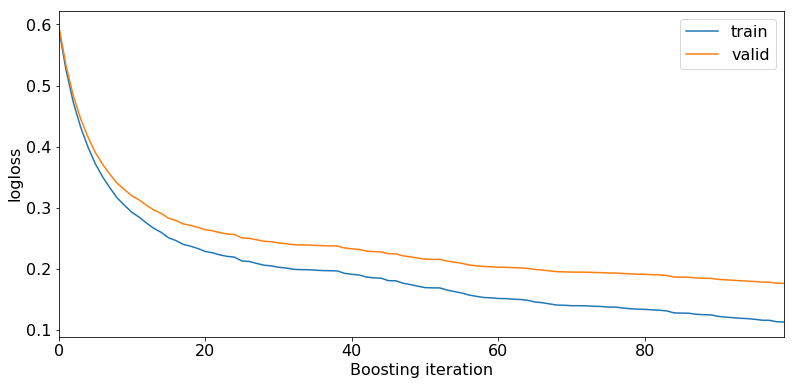

In [8]:
df_score = pd.DataFrame({'train':evals_result['train']['logloss'],
                         'valid':evals_result['valid']['logloss']})
df_score.plot(figsize=(13, 6))
plt.ylabel("logloss")
plt.xlabel("Boosting iteration")

In [9]:
params_xgb.update({'process_type': 'update',
                   'updater'     : 'refresh',
                   'refresh_leaf': False,
                  })

In [10]:
t0 = time.time()
print("Refreshing ...")
bst_after = xgb.train(params_xgb, xgmat_valid, n_rounds, xgb_model=bst)
print("Done: %.1fs" % (time.time() - t0))

Refreshing ...
Done: 0.6s


In [11]:
imp_2 = pd.DataFrame(index=xgmat_train.feature_names)
imp_2['train'] = pd.Series(bst.get_score(importance_type='gain'))
imp_2['OOB'] = pd.Series(bst_after.get_score(importance_type='gain'))
imp_2 = imp_2.fillna(0)
imp_2 /= imp_2.sum(0)*.01
imp_2 = imp_2.sort_values('train')
print(imp_2.tail())

        train       OOB
f36  3.774738  3.721348
f44  3.814734  3.956078
f45  5.003247  4.501594
f35  6.052359  7.055316
f00  6.296838  5.977178


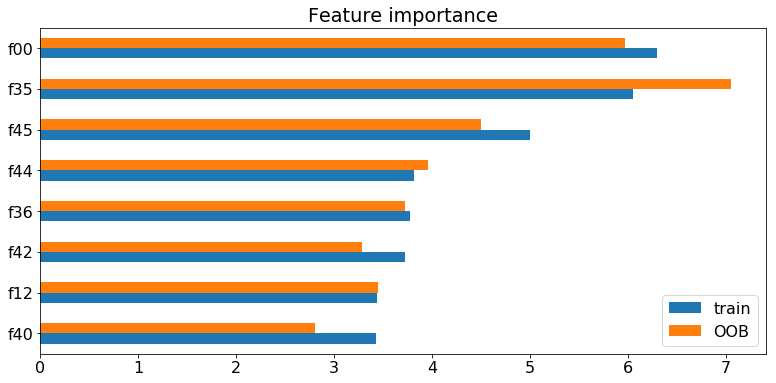

In [12]:
imp_2.tail(8).plot(kind='barh', title="Feature importance", figsize=(13, 6))

In [13]:
key = 'lambda'
val_lst = [0, 1, 2, 4, 8]
t0 = time.time()
bst_lst = []
print("Refreshing ...")
for val in val_lst:
    params_xgb[key] = val
    bst_lst.append(xgb.train(params_xgb, xgmat_valid, n_rounds, xgb_model=bst))
    print("%s:%d done: %.1fs" % (key, val, (time.time() - t0)))

Refreshing ...
lambda:0 done: 0.6s
lambda:1 done: 1.2s
lambda:2 done: 2.0s
lambda:4 done: 3.1s
lambda:8 done: 3.7s


In [14]:
imp_s = pd.DataFrame(index=xgmat_train.feature_names)
imp_s['train'] = pd.Series(bst.get_score(importance_type='gain'))
for val, bst_after in zip(val_lst, bst_lst):
    imp_s['%s_%d' % (key, val)] = pd.Series(bst_after.get_score(importance_type='gain'))

imp_s = imp_s.fillna(0)
imp_s /= imp_s.sum(0)*.01
imp_s = imp_s.sort_values('train')
print(imp_s.tail())

        train  lambda_0  lambda_1  lambda_2  lambda_4  lambda_8
f36  3.774738  3.554904  3.721348  3.835851  3.998860  4.216160
f44  3.814734  3.803330  3.956078  4.048755  4.159970  4.264180
f45  5.003247  4.284733  4.501594  4.653882  4.876409  5.184760
f35  6.052359  6.702117  7.055316  7.309189  7.684033  8.202731
f00  6.296838  5.671748  5.977178  6.208649  6.572738  7.127191


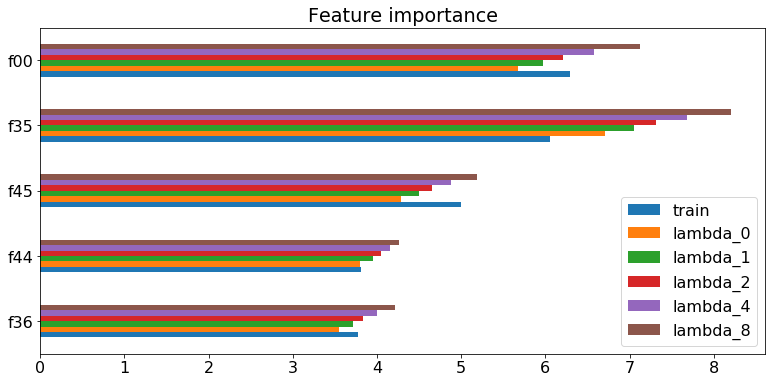

In [15]:
imp_s.tail(5).plot(kind='barh', title="Feature importance", figsize=(13, 6))